# Py-regallo Tutorial

## Introduction
Looking at the project source tree, it consists of the following modules:
### cfg
It includes all classes that build the Control Flow Graph such as:

- **Variable** - represents a values used by the program that is allocable (constants or labels are not Variables). Variables have unique id of the form "v[0-9]+".
- **Instruction** - represents a single instruction. It has an opname (e.g. "add", "mov", "br"), stores Variable definition and the list of Variable it uses. 
- **BasicBlock** - consists of list of instructions. It is a vertice in the Control Flow Graph. Stores lists of its predecessors and successors. Like Variables, BasicBlocks have unique ids of the form 'bb[0-9]+'. 
- **Function** - represents a function as a Control Flow Graph on BasicBlocks. 
- **Module** - made up of a list of functions, typically all the functions from the particular file. 


Registers, memory slots, constants and labels are represented as strings as follows:

- **register** - 'reg[0-9]+'
- **memory slot** - 'mem([0-9]+)
- **constant** - 'const' (we don't distinguish between constants - it's not important for register allocators)
- **labels** - 'bb[0-9]+' 

### cfg.resolve
Includes functions for translating the program out of SSA form and inserting spill code (load and store instructions)

### cfg.printer
Contains helper classes for various objects printing. For instance, FunctionString, InstructionString, IntervalsString are responsible for printing Function, Instruction and Intervals respectively.

### allocators
Here are all register allocators implemented. It also includes an interface each allocator should apply to.

### cost
Set of cost calculators computing an integer cost for each Instruction, BasicBlock and Function.

## Loading programs from json and data flow analysis.
A json file generated by our LLVM plugin can be loaded into a module which will give as access to all the functions. We show it on example of a program calculating GCD (greatest common divisor), consisting only of two functions 'gcd' and 'main'. After reading the json we perform full data flow analysis which includes, among others, instruction numbering, liveness analysis, dominance analysis and building loop nesting forest. At the end we print out the function using the cfg.printer.

In [1]:
import cfg
from cfg.printer import FunctionString

m = cfg.Module.from_file("programs/gcd.json")
m.perform_full_analysis()

print "Available functions: ", ", ".join(m.functions.keys()), "\n"

gcd = m.functions['gcd']
print FunctionString(gcd)

Available functions:  main, gcd 

bb1(entry)
  0: v1 = icmp v2 v3 
  1: v4 = br v1 bb3 bb2 


bb2(if.then)
  2: v5 = xor v2 v3 
  3: v6 = xor v3 v5 
  4: v7 = xor v5 v6 
  5: v8 = br bb3                 


bb3(if.end)
  6: v9 = phi bb2 -> v6 bb1 -> v3 
  7: v10 = phi bb2 -> v7 bb1 -> v2 
  8: v11 = br bb4                 


bb4(while.cond)
  9: v12 = phi bb5 -> v13 bb3 -> v9 
 10: v14 = phi bb5 -> v12 bb3 -> v10 
 11: v15 = icmp v12 const 
 12: v16 = br v15 bb6 bb5 


bb5(while.body)
 13: v13 = srem v14 v12 
 14: v17 = br bb4                 


bb6(while.end)
 15: v18 = ret v14    




When using any ObjectString from cfg.printer, we can pass options saying what we want to include in the object description. Here, apart from the sole function body, we can print for example predecessors, successors, liveness sets and dominance sets.

In [2]:
from cfg.printer import Opts
print FunctionString(gcd, Opts(predecessors=True, successors=True, liveness=True, dominance=True))

bb1(entry)
  0: v1 = icmp v2 v3 
  1: v4 = br v1 bb3 bb2 
     PREDS: []
     SUCCS: [bb3, bb2]
   LIVE-IN: [v2, v3]
  LIVE-OUT: [v2, v3]
       DOM: [bb1]


bb2(if.then)
  2: v5 = xor v2 v3 
  3: v6 = xor v3 v5 
  4: v7 = xor v5 v6 
  5: v8 = br bb3                 
     PREDS: [bb1]
     SUCCS: [bb3]
   LIVE-IN: [v2, v3]
  LIVE-OUT: [v6, v7]
       DOM: [bb1, bb2]


bb3(if.end)
  6: v9 = phi bb2 -> v6 bb1 -> v3 
  7: v10 = phi bb2 -> v7 bb1 -> v2 
  8: v11 = br bb4                 
     PREDS: [bb2, bb1]
     SUCCS: [bb4]
   LIVE-IN: []
  LIVE-OUT: [v9, v10]
       DOM: [bb1, bb3]


bb4(while.cond)
  9: v12 = phi bb5 -> v13 bb3 -> v9 
 10: v14 = phi bb5 -> v12 bb3 -> v10 
 11: v15 = icmp v12 const 
 12: v16 = br v15 bb6 bb5 
     PREDS: [bb5, bb3]
     SUCCS: [bb6, bb5]
   LIVE-IN: []
  LIVE-OUT: [v12, v14]
       DOM: [bb1, bb3, bb4]


bb5(while.body)
 13: v13 = srem v14 v12 
 14: v17 = br bb4                 
     PREDS: [bb4]
     SUCCS: [bb4]
   LIVE-IN: [v12, v14]
  LIVE-OUT: [v

### Liveness analysis
We use a simple round-robin algorithm for computing liveness sets, described e.g. in *[1] (Cooper, Torczon) 9.2.2 Live-Variable Analysis 482-490*. <br>

Since the program is in SSA form, we need to apply some modification relating to phi functions. We treat
the variables used in phi functions in a basic block as **live-out** in the corresponding predecessor but NOT **live-in** at this basic block. <br>

It makes sense because after PHI elimination these particular uses of variables will be situated at the end of the predecessor block. It is also helpful during intervals building in linear scan register allocation - phi operations assume parallel copies between from uses to corresponding definitions, so during register allocation intervals of uses should not intersect with intervals of variables defined by phi instructions. The copies are inserted during phi elimination phase which also deals with all register conflicts.

## Linear scan register allocation
We show how it works on basic version of linear scan algorithm.

### Intervals building
The first stage of linear scan algorithm is bulding lifetime intervals. In a most basic form, a lifetime
interval of a variable is a connected segment of instructions where the variable can be "live" 
(usually: from its definition up to the last use of this variable in the program). <br>

Below we create an object of BasicLinearScan, build lifetime intervals from our function and print it out.
Because register allocation may change the structure of the function, we make a copy of f at first, in case we want to reuse it later.

In [3]:
g = gcd.copy()

from allocators.lscan.basic import BasicLinearScan
from cfg.printer import IntervalsString

bls = BasicLinearScan()
intervals = bls.compute_intervals(g)
print IntervalsString(intervals)

INTERVAL             VAR-ID       REG    
[-0.5, 2]            v2            -     
[-0.5, 3]            v3            -     
[0, 1]               v1            -     
[2, 4]               v5            -     
[3, 5.5]             v6            -     
[4, 5.5]             v7            -     
[6, 8.5]             v9            -     
[7, 8.5]             v10           -     
[9, 14.5]            v12           -     
[10, 15]             v14           -     
[11, 12]             v15           -     
[13, 14.5]           v13           -     




Let's pay our attention to the intervals with non-integer endpoints like [-0.5, 2] or [9, 14.5]. It occurs at the beginning or end of the basic block, when a variable is live-in or live-out at this block - we add then respectively (-0.5) or 0.5 to the instruction number. It helps for example to distinguish between variables ending at the last instruction of the basic block, from those which are live-out at this block and used in the successor's phi-instruction (where the interval shouldn't reach because the variable, as we mentioned earlier, is not live there anymore). It also solves a few other problems that need however more detailed explanation. <br> <br>

Apart from printing out intervals' endpoints, we can draw them on a chart in a following way:

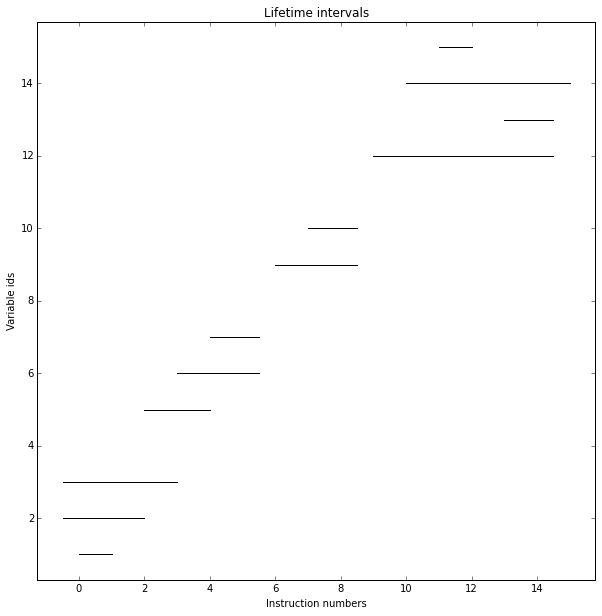

In [4]:
import utils
%matplotlib inline
utils.draw_intervals(intervals, figsize=(10, 10))

All the intervals are black because they don't have any regisers assigned.

### Register allocation
Linear scan allocator takes as input the intervals and number of free registers. It processes the intervals in the order of their left endpoints and tries to allocate a free register to each variable. If, at the given moment, there are no free registers, an interval is chosen for spilling. In default strategy, from all *active* intervals, it chooses the one with the furthest end. <br><br>
The variable whose interval was spilled is assigned a memory slot. Inserting load and store instructions is performed later and is independent from register allocation.<br>

In the example below we try to allocate the variables only to 2 registers. As we can see, the allocator spilled two variables into memory, which means 2 registers it's not enough.

INTERVAL             VAR-ID       REG    
[-0.5, 2]            v2           reg2   
[-0.5, 3]            v3            -     
[0, 1]               v1           reg1   
[2, 4]               v5           reg1   
[3, 5.5]             v6           reg2   
[4, 5.5]             v7           reg1   
[6, 8.5]             v9           reg2   
[7, 8.5]             v10          reg1   
[9, 14.5]            v12          reg2   
[10, 15]             v14           -     
[11, 12]             v15          reg1   
[13, 14.5]           v13          reg1   




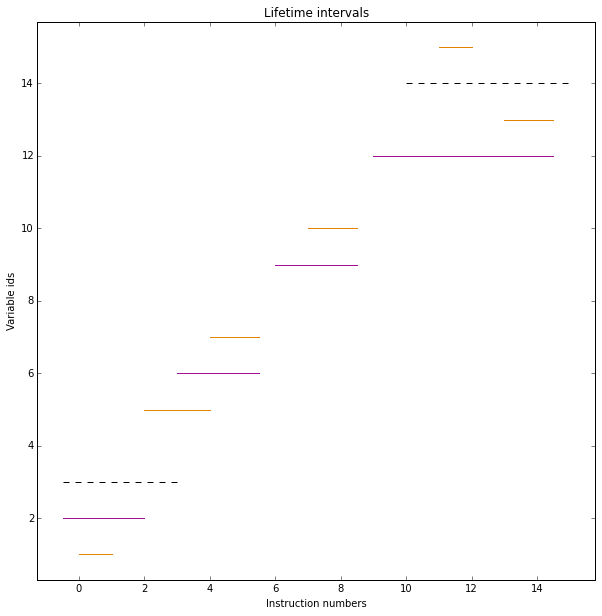

In [5]:
bls.allocate_registers(intervals, 2)
print IntervalsString(intervals)
utils.draw_intervals(intervals, regcount=2, figsize=(10, 10))

In the picture above, intervals with the same colored have the same registers assigned. Spilled intervals are distinguished by a dashed line.

### Spill code insertion
Now we can insert store and load instructions in appropriate points of the program and see how the modified function looks like. It should lower the register pressure and help the register allocator finish the job.

In [6]:
cfg.resolve.insert_spill_code(g)
print FunctionString(g)

bb1(entry)
   > v25 = load_ mem(v3)             
  0: v1 = icmp v2 v25 
  1: v4 = br v1 bb3 bb2 
   > v22 = load_ mem(v3)             


bb2(if.then)
   > v23 = load_ mem(v3)             
  2: v5 = xor v2 v23 
   > v24 = load_ mem(v3)             
  3: v6 = xor v24 v5 
  4: v7 = xor v5 v6 
  5: v8 = br bb3                 


bb3(if.end)
  6: v9 = phi bb2 -> v6 bb1 -> v22 
  7: v10 = phi bb2 -> v7 bb1 -> v2 
  8: v11 = br bb4                 


bb4(while.cond)
  9: v12 = phi bb5 -> v13 bb3 -> v9 
 10: v21 = phi bb5 -> v12 bb3 -> v10 
   > store_ mem(v14) v21 
 11: v15 = icmp v12 const 
 12: v16 = br v15 bb6 bb5 


bb5(while.body)
   > v20 = load_ mem(v14)            
 13: v13 = srem v20 v12 
 14: v17 = br bb4                 


bb6(while.end)
   > v19 = load_ mem(v14)            
 15: v18 = ret v19    




The instructions without numbers are the load and stores. Let's take into account that inserting new instructions changes the structure of the cfg, so we need to repeat the data flow analysis.

In [7]:
g.perform_full_analysis()

### Repeat register allocation
We build the intervals again and retry register allocation.

INTERVAL             VAR-ID       REG    
[-0.5, 5]            v2            -     
[0, 1]               v25           -     
[1, 2]               v1            -     
[3, 3.5]             v22           -     
[4, 5]               v23           -     
[5, 8]               v5            -     
[6, 7]               v24           -     
[7, 9.5]             v6            -     
[8, 9.5]             v7            -     
[10, 12.5]           v9            -     
[11, 12.5]           v10           -     
[13, 20.5]           v12           -     
[14, 15]             v21           -     
[16, 17]             v15           -     
[18, 19]             v20           -     
[19, 20.5]           v13           -     
[21, 22]             v19           -     




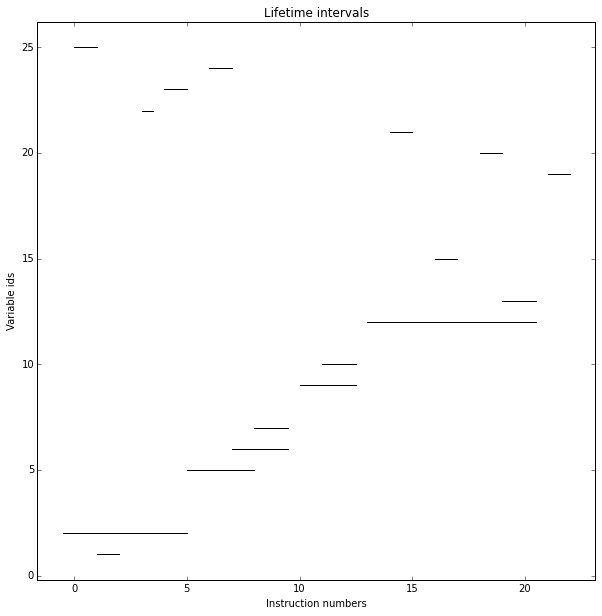

In [8]:
intervals = bls.compute_intervals(g)
print IntervalsString(intervals)
utils.draw_intervals(intervals, regcount=2, figsize=(10, 10))


INTERVAL             VAR-ID       REG    
[-0.5, 5]            v2           reg2   
[0, 1]               v25          reg1   
[1, 2]               v1           reg1   
[3, 3.5]             v22          reg1   
[4, 5]               v23          reg1   
[5, 8]               v5           reg2   
[6, 7]               v24          reg1   
[7, 9.5]             v6           reg1   
[8, 9.5]             v7           reg2   
[10, 12.5]           v9           reg1   
[11, 12.5]           v10          reg2   
[13, 20.5]           v12          reg1   
[14, 15]             v21          reg2   
[16, 17]             v15          reg2   
[18, 19]             v20          reg2   
[19, 20.5]           v13          reg2   
[21, 22]             v19          reg1   




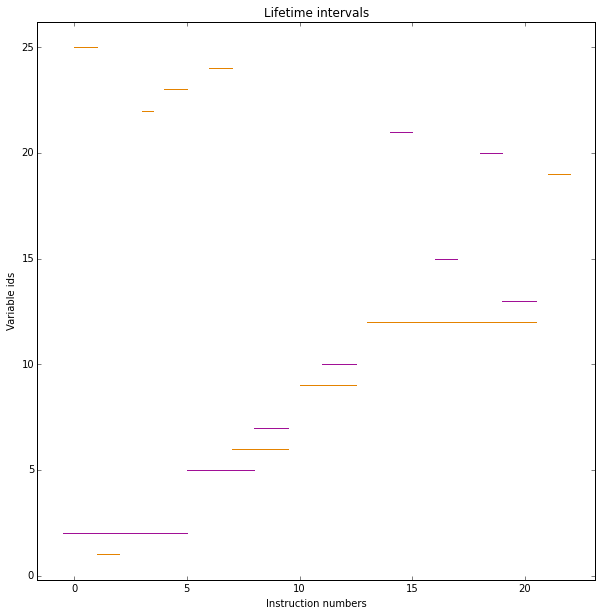

In [9]:
bls.allocate_registers(intervals, 2)
print IntervalsString(intervals)
utils.draw_intervals(intervals, regcount=2, figsize=(10, 10))

Now the allocator finished successfully. Now we can print out the cfg replacing variables with their allocated registers. 

In [10]:
print FunctionString(g, Opts(with_alloc=True, liveness=True))

bb1(entry)
  0: v25(reg1) = load_ mem(v3)    
  1: v1(reg1) = icmp v2(reg2) v25(reg1) 
  2: v4 = br v1(reg1) bb3 bb2 
  3: v22(reg1) = load_ mem(v3)    
   LIVE-IN: [v2]
  LIVE-OUT: [v2, v22]


bb2(if.then)
  4: v23(reg1) = load_ mem(v3)    
  5: v5(reg2) = xor v2(reg2) v23(reg1) 
  6: v24(reg1) = load_ mem(v3)    
  7: v6(reg1) = xor v24(reg1) v5(reg2) 
  8: v7(reg2) = xor v5(reg2) v6(reg1) 
  9: v8 = br bb3                 
   LIVE-IN: [v2]
  LIVE-OUT: [v6, v7]


bb3(if.end)
 10: v9(reg1) = phi bb2 -> v6(reg1) bb1 -> v22(reg1) 
 11: v10(reg2) = phi bb2 -> v7(reg2) bb1 -> v2(reg2) 
 12: v11 = br bb4                 
   LIVE-IN: []
  LIVE-OUT: [v9, v10]


bb4(while.cond)
 13: v12(reg1) = phi bb5 -> v13(reg2) bb3 -> v9(reg1) 
 14: v21(reg2) = phi bb5 -> v12(reg1) bb3 -> v10(reg2) 
 15: store_ mem(v14) v21(reg2) 
 16: v15(reg2) = icmp v12(reg1) const 
 17: v16 = br v15(reg2) bb6 bb5 
   LIVE-IN: []
  LIVE-OUT: [v12]


bb5(while.body)
 18: v20(reg2) = load_ mem(v14)   
 19: v13(reg2) = sr

### Translating out of SSA form (PHI elimination)
The last thing we have to do is to translate the program out of SSA form. To do that, we use algorithm from *[4] S.Hack: 4.4 Implementing Phi-Operations: 55-58* . It boils down to inserting (definition, use) moves in a proper order and proper place in the control flow graph. Let's see the function afther phi destruction. 

In [11]:
cfg.resolve.eliminate_phi(g, 2)
print FunctionString(g, Opts(with_alloc=True))

bb1(entry)
  0: v25(reg1) = load_ mem(v3)    
  1: v1(reg1) = icmp v2(reg2) v25(reg1) 
  2: v4 = br v1(reg1) bb3 bb2 
  3: v22(reg1) = load_ mem(v3)    


bb2(if.then)
  4: v23(reg1) = load_ mem(v3)    
  5: v5(reg2) = xor v2(reg2) v23(reg1) 
  6: v24(reg1) = load_ mem(v3)    
  7: v6(reg1) = xor v24(reg1) v5(reg2) 
  8: v7(reg2) = xor v5(reg2) v6(reg1) 
  9: v8 = br bb3                 
   > v9(reg1) = mov v6(reg1) 
   > v10(reg2) = mov v7(reg2) 


bb7(None)
   > v9(reg1) = mov v22(reg1) 
   > v10(reg2) = mov v2(reg2) 


bb3(if.end)
 12: v11 = br bb4                 
   > v12(reg1) = mov v9(reg1) 
   > v21(reg2) = mov v10(reg2) 


bb4(while.cond)
 15: store_ mem(v14) v21(reg2) 
 16: v15(reg2) = icmp v12(reg1) const 
 17: v16 = br v15(reg2) bb6 bb5 


bb5(while.body)
 18: v20(reg2) = load_ mem(v14)   
 19: v13(reg2) = srem v20(reg2) v12(reg1) 
 20: v17 = br bb4                 
   > store_ mem(v26) v12(reg1) 
   > v12(reg1) = mov v13(reg2) 
   > v21(reg2) = load_ mem(v26)   


bb6(whil

On the listing above we can see all the moves generated by phi elimination, even those between variables sharing the same register. We can also see a new BasicBlock, created on the edge between blocks bb1 and bb3 because bb1 have multiple successors. Passing **reg_only=True** to the printer options, we will get function cfg without redundant instructions and basic blocks.

In [12]:
print FunctionString(g, Opts(alloc_only=True))

bb1(entry)
  0: reg1 = load_ mem(v3)    
  1: reg1 = icmp reg2 reg1 
  2: v4 = br reg1 bb3 bb2 
  3: reg1 = load_ mem(v3)    


bb2(if.then)
  4: reg1 = load_ mem(v3)    
  5: reg2 = xor reg2 reg1 
  6: reg1 = load_ mem(v3)    
  7: reg1 = xor reg1 reg2 
  8: reg2 = xor reg2 reg1 
  9: v8 = br bb3                 


bb3(if.end)
 12: v11 = br bb4                 


bb4(while.cond)
 15: store_ mem(v14) reg2 
 16: reg2 = icmp reg1 const 
 17: v16 = br reg2 bb6 bb5 


bb5(while.body)
 18: reg2 = load_ mem(v14)   
 19: reg2 = srem reg2 reg1 
 20: v17 = br bb4                 
   > store_ mem(v26) reg1 
   > reg1 = mov reg2       
   > reg2 = load_ mem(v26)   


bb6(while.end)
 21: reg1 = load_ mem(v14)   
 22: v18 = ret reg1       




At the end, as before, it's good to repeat data flow analysis.

In [13]:
g.perform_full_analysis()

# Cost of allocation

At the end we can calculate the cost of the register allocation which constitutes our final result. Cost is computed per each instruction separately and summed up at the end. Our main cost calculator depends on 3 parameters: load/store instruction cost, all remaining instructions cost, loop nesting cost. On default, they are equal to 2, 1, 10 respectively.

In [14]:
from cost import BasicCostCalculator
from cfg.printer import CostString

bcc = BasicCostCalculator()
print CostString(g, bcc)

Default (2, 1, 10)
  LOOP     COST               INSTR             
   0       2.0      0: reg1 = load_ mem(v3)    
   0       1.0      1: reg1 = icmp reg2 reg1 
   0       1.0      2: v4 = br reg1 bb3 bb2 
   0       2.0      3: reg1 = load_ mem(v3)    
   0       2.0      4: reg1 = load_ mem(v3)    
   0       1.0      5: reg2 = xor reg2 reg1 
   0       2.0      6: reg1 = load_ mem(v3)    
   0       1.0      7: reg1 = xor reg1 reg2 
   0       1.0      8: reg2 = xor reg2 reg1 
   0       1.0      9: v8 = br bb3                 
   0        0      10: reg1 = mov reg1       
   0        0      11: reg2 = mov reg2       
   0        0      12: reg1 = mov reg1       
   0        0      13: reg2 = mov reg2       
   0       1.0     14: v11 = br bb4                 
   0        0      15: reg1 = mov reg1       
   0        0      16: reg2 = mov reg2       
   1       20.0    17: store_ mem(v14) reg2 
   1       10.0    18: reg2 = icmp reg1 const 
   1       10.0    19: v16 = br reg2 bb6 

## Full register allocation
It was good to make a step-by-step introduction. In practice however, there is a function which does all these steps for us and returns true or false meaning if allocation succeeded or not. It looks like this:

In each step of the main loop it runs a specific register allocator (all the details like intervals building in case of linear scan are kept inside) with a given number of available registers. In its first phase it tries to allocate *regcount* registers with possible spilling. If there are spilled variables, it generates store and loads instructions and on the modified program runs the allocator once again with spilling turned off. If it succeeds, phi elimination is executed and all the necessary data-flow analysis. Otherwise, it repeats the process, in the first phase passing one less register *regcount - 1*. It will produce more spill code but it will be easier to allocate registers in the second phase. Again, if it fails, we repeat everything passing *regcount - 2* to the first phase allocation until we reach 0.  

In [15]:
h = gcd.copy() # one more copy of gcd
success = bls.perform_full_register_allocation(h, 2)
cost = bcc.function_cost(h)
print "Success:", success, "| Cost:", cost

Success: True | Cost: 148.0


## Comparing different algorithms
It is easy to compare different algorithms on a set of functions for multiple regcounts, using various cost calculatoros.

In [16]:
import allocators.lscan.basic.spillers as spillers
from allocators.lscan.extended import ExtendedLinearScan
from cost import SpillRatioCalculator, BasicCostCalculator

# Allocators
bas = BasicLinearScan(name="basic furthest first")
bas_cf = BasicLinearScan(spiller=spillers.CurrentFirst(), name="basic current first")
bas_luf = BasicLinearScan(spiller=spillers.LessUsedFirst(), name="basic less used first")

ext = ExtendedLinearScan(name="extended default")

# Cost calculators
bcc = BasicCostCalculator()
src = SpillRatioCalculator()

# Setup
setting = utils.ResultCompSetting(
    functions = m.functions.values(), 
    regcounts = [1, 2, 3], 
    allocators = [bas, bas_cf], 
    cost_calculators = [bcc, src])

print "Comparing \'furthest first\' and \'current first\' strategies."
result_table = utils.compute_full_results(setting)
utils.print_result_table(result_table, setting)
print "\n"

print "Comparing BasicLinearScan and ExtendedLinearScan"
setting = utils.ResultCompSetting(
    functions = m.functions.values(), 
    regcounts = [1, 2, 3], 
    allocators = [bas, ext], 
    cost_calculators = [bcc, src])

result_table = utils.compute_full_results(setting)
utils.print_result_table(result_table, setting)

Comparing 'furthest first' and 'current first' strategies.
+-----------------------+----------------------------------+----------------------------------+
|                       | basic furthest first             | basic current first              |
+-----------+-----------+--------------------+-------------+--------------------+-------------+
| Functions | Registers | Default (2, 1, 10) | Spill Ratio | Default (2, 1, 10) | Spill Ratio |
+-----------+-----------+--------------------+-------------+--------------------+-------------+
| main      | 1         | Failed             | Failed      | Failed             | Failed      |
|           +-----------+--------------------+-------------+--------------------+-------------+
|           | 2         | 144.0              | 0           | 364.0              | 0           |
|           +-----------+--------------------+-------------+--------------------+-------------+
|           | 3         | 104.0              | 0           | 244.0           

## References
[1] K. Cooper, L. Torczon. Engineering a Compiler. Second Edition, 2012 <br>
[2] C. Wimmer and M. Franz. Linear Scan Register Allocation on SSA Form <br>
[3] C. Wimmer and H. Mossenbock. Optimized interval splitting in a linear scan register allocator. <br>
[4] S. Hack. Register Allocation for Programs in SSA Form, 2006.